# Modeling and Evaluation

This notebook is just the first model, checking how everything works. No location key.

In [1]:
#Importing general packages
import pandas as pd
import MySQLdb as mdb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nets_data = pd.read_csv('nets_cleaned_data.csv')

In [3]:
nets_data = nets_data.set_index('instance')

In [4]:
nets_data.drop('conference', axis=1, inplace=True) #left it there by accident

In [5]:
nets_data.head()

,begseat,endseat,quantity,sold,year,month,dayofweek,time_left,price,nets_losses,...,26,28,29,3.2,31,4.2,6.1,7.1,8.1,9.1
instance,,,,,,,,,,,,,,,,,,,,,
01/02/2017_1/15/1.0/2.0,1,2,2,0,2017,2,2,1,83.640,40,...,0,0,0,0,0,0,0,0,0,0
01/02/2017_1/15/12.0/13.0,12,13,2,1,2017,2,2,0,75.480,40,...,0,0,0,0,0,0,0,0,0,0
01/02/2017_1/15/14.0/15.0,14,15,2,0,2017,2,2,0,77.220,40,...,0,0,0,0,0,0,0,0,0,0
01/02/2017_1/15/3.0/6.0,3,6,4,1,2017,2,2,2,116.585,40,...,0,0,0,0,0,0,0,0,0,0
01/02/2017_1/16/1.0/2.0,1,2,2,0,2017,2,2,1,79.560,40,...,0,0,0,0,0,0,0,0,0,0


In [6]:
unsold = (nets_data['sold'] == 1).sum()
base_rate = unsold/len(nets_data)
print(base_rate*100,'%')

9.476531206135096 %


In [7]:
#sklearn packages
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing

In [8]:
X = nets_data.loc[:, nets_data.columns != 'sold'] #Select everything but sold
Y = nets_data['sold']

**Scaling**

Using Min-Max Scaler to shrink the numerical data to a number between 0 and 1. Need to experiment with Standard Scaler but I hypothesize some of the features are not normally distributed (e.g. the number of allstars since greater players like to play with each other, and large market teams tend to attract allstars). 

In [9]:
columns_to_scale = ['begseat', 'endseat', 'quantity', 'year', 'month', 'dayofweek', 
                    'time_left', 'price', 'nets_losses', 'opp_losses', 'opp_wins', 
                    'allstars_count','rounds', 'losses', 'oppg', 'ppg', 'seed', 'winloss', 'wins']

In [10]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

X[columns_to_scale] = mms.fit_transform(X[columns_to_scale])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Model Selection

**Preprocessing:** Basic feature selection to reduce the size of the dataset

We begin by using RandomForestClassifier and feature importance from sklearn to reduce the number of variables. In this case, we will be using entropy/information gain as the criterion. As the classifier trains the tree, it will also compute how much each feature decreases the weighted impurity in a tree. The impurity decrease from each feature is averaged and ranked. We can control the threshold for which a feature is considered significant in SelectFromModel. Based on domain knowledge, we are confident that many of the features will not contribute much to whether a ticket is sold, such as the presence of a role players. Hence, we will arbitrarily reduce the features down to around the 100 most significant, and then perform further complexity controls later.

In [12]:
clf = RandomForestClassifier(criterion='entropy')
clf = clf.fit(X, Y)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True, threshold=0.0015)
X_new = model.transform(X)
X_new.shape                    #(100000, 5)

(58418, 97)

In [13]:
#Let's get the relevant columns and split data for training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=0.33) #Split 66% vs 33%

**Quick Complexity Controls:** We will begin by generating several models and performing some basic fitting to ensure that the models are generalizable. While our ROC and Lift model comparisons are performed on test data (hence, overfitting is not a relevant issue in terms of showing the suitability of the model), we found it more computationally efficient to simplify the models earlier on before further analyses. We will be plotting fitting curves against AUC. As mentioned, our dataset is heavily skewed and accuracy is not a good performance measure.

We will examine 5 models in this project. 1) Simple Classification Tree 2) Random Forest 3) Logistic Regression 4) Naive Bayes. 

(*We were curious about SVM, but it was too slow and computationally intensive for the tools we have right now*)

--------

**1. Simple decision tree classifer**

`Insert text explaining the decision tree classifier briefly`

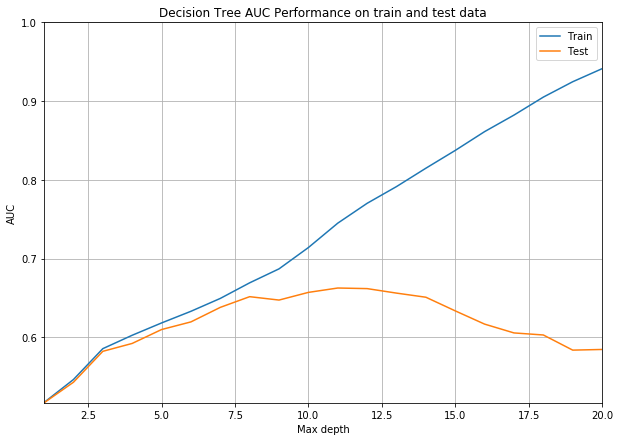

In [79]:
auc_train = []
auc_test = []
maxdepth = 20
depths = range(1, maxdepth+1)

fig, ax = plt.subplots(figsize=(10, 7))

for md in depths:
    model = DecisionTreeClassifier(max_depth=md)
    model.fit(X_train, Y_train)
    
    # Get the probability of Y_test records being = 1
    Y_train_probability_1 = model.predict_proba(X_train)[:, 1]
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(Y_train, Y_train_probability_1)
    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(Y_test, Y_test_probability_1)
    
    auc_train.append(metrics.auc(fpr_train, tpr_train))
    auc_test.append(metrics.auc(fpr_test, tpr_test))
    
plt.plot(depths, auc_train, label="Train")
plt.plot(depths, auc_test, label="Test")
plt.title("Decision Tree AUC Performance on train and test data")
plt.xlabel("Max depth")
plt.ylabel("AUC")
plt.ylim([min(auc_test), 1.0])
plt.xlim([1,maxdepth])
plt.legend()
plt.grid()
plt.show()

fig.savefig('Tree_Fitting.png')

**2. Random Forest**

`Insert text to explain random forest`

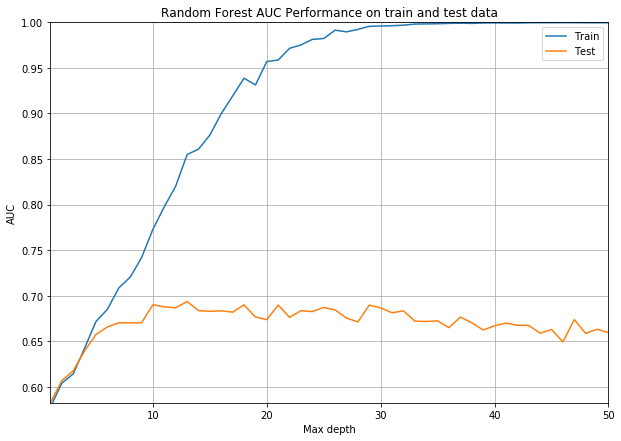

In [14]:
auc_train = []
auc_test = []
maxdepth = 50
depths = range(1, maxdepth+1)

fig, ax = plt.subplots(figsize=(10, 7))

for md in depths:
    model = RandomForestClassifier(max_depth=md)
    model.fit(X_train, Y_train)
    
    # Get the probability of Y_test records being = 1
    Y_train_probability_1 = model.predict_proba(X_train)[:, 1]
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(Y_train, Y_train_probability_1)
    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(Y_test, Y_test_probability_1)
    
    auc_train.append(metrics.auc(fpr_train, tpr_train))
    auc_test.append(metrics.auc(fpr_test, tpr_test))
    
plt.plot(depths, auc_train, label="Train")
plt.plot(depths, auc_test, label="Test")
plt.title("Random Forest AUC Performance on train and test data")
plt.xlabel("Max depth")
plt.ylabel("AUC")
plt.ylim([min(auc_test), 1.0])
plt.xlim([1,maxdepth])
plt.legend()
plt.grid()
plt.show()

fig.savefig('RF_Fitting.png')

**3. Logistic Regression (Regularization)**

`Insert text to explain Logistic Regression`

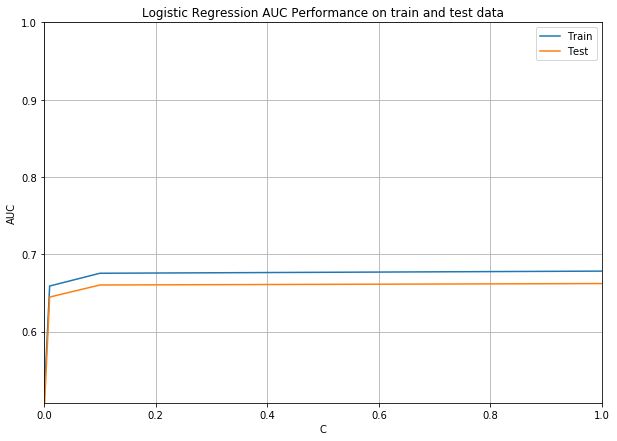

In [77]:
auc_train = []
auc_test = []

fig, ax = plt.subplots(figsize=(10, 7))

c_list = [0.001, 0.01, 0.1, 1.0]

for c in c_list:
    model = LogisticRegression(C=c)
    model.fit(X_train, Y_train)

    
    # Get the probability of Y_test records being = 1
    Y_train_probability_1 = model.predict_proba(X_train)[:, 1]
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(Y_train, Y_train_probability_1)
    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(Y_test, Y_test_probability_1)
    
    auc_train.append(metrics.auc(fpr_train, tpr_train))
    auc_test.append(metrics.auc(fpr_test, tpr_test))
    
plt.plot(c_list, auc_train, label="Train")
plt.plot(c_list, auc_test, label="Test")
plt.title("Logistic Regression AUC Performance on train and test data")
plt.xlabel("C")
plt.ylabel("AUC")
plt.ylim([min(auc_test), 1.0])
plt.xlim([0,1])
plt.legend()
plt.grid()
plt.show()

fig.savefig('Logit_Fitting.png')

Seems like the scaling and preliminary feature selection did a lot of the work already, regularization does not seem to improve performance much.

**4. Naive Bayes Classifier**

`Insert text to explain Naive Bayes Gaussian. No tuning paramter, so no fitting curve`

-----------------

**Comparing Models with ROC Curve(AUC), Lift and Profit Curves**

In [15]:
#Colour-coder

def colour_coder(model_type):
    if model_type == "decision_tree":
        return "#2ca02c" #green
    elif model_type == "random_forest":
        return "#1f77b4" #blue
    elif model_type == "logistic_regression":
        return "#ff7f0e" #orange
    elif model_type == "naive_bayes":
        return "#d62728" #red

**ROC Curve**

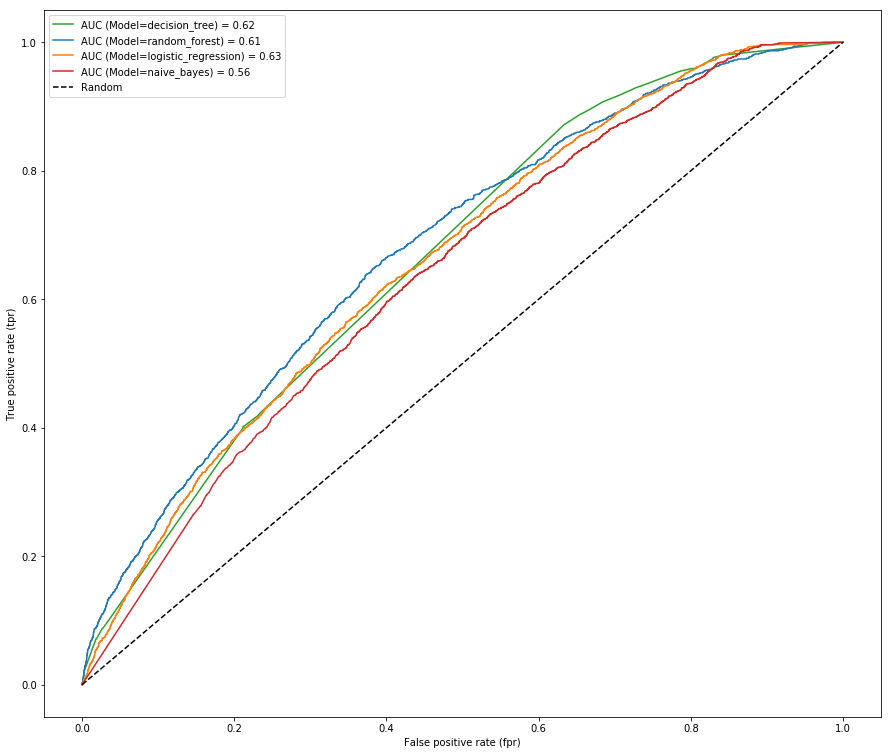

In [80]:
#ROC Curve with AUC Values

# Fit models
fig, ax = plt.subplots(figsize=(15, 13))

model_types = ["decision_tree", "random_forest", "logistic_regression", "naive_bayes"]

for model_type in model_types:
    if model_type == "decision_tree":
        model = DecisionTreeClassifier(criterion="entropy", max_depth=10)
    elif model_type == "random_forest":
        model = RandomForestClassifier(max_depth=11)
    elif model_type == "logistic_regression":
        model = LogisticRegression(C=0.1)
    elif model_type == "naive_bayes":
        model = GaussianNB()
    model.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
    
    # Get the area under the curve (AUC)
    auc = np.mean(cross_val_score(model, X, Y, scoring="roc_auc"))

    # Plot the ROC curve
    plt.plot(fpr, tpr, label="AUC (Model=" + str(model_type) + ") = " + str(round(auc, 2)), color=colour_coder(model_type))
    
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc=2)

fig.savefig('ROC_Curve.png', dpi=300)

**Lift Curve**

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


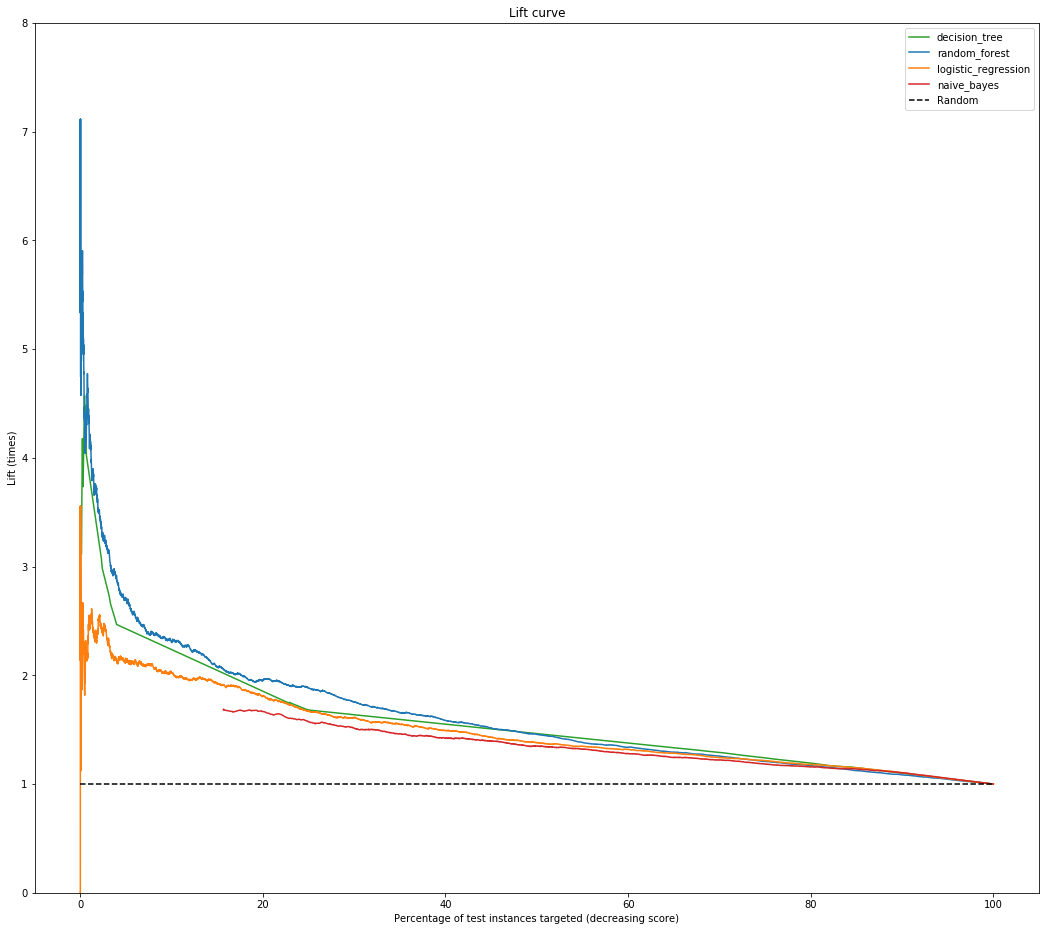

In [83]:
xs = {}
ys = {}

fig, ax = plt.subplots(figsize=(18, 16))

for model_type in model_types:
    if model_type == "decision_tree":
        model = DecisionTreeClassifier(criterion="entropy", max_depth=10)
    elif model_type == "random_forest":
        model = RandomForestClassifier(max_depth=12)
    elif model_type == "logistic_regression":
        model = LogisticRegression(C=0.1)
    elif model_type == "naive_bayes":
        model = GaussianNB()
    model.fit(X_train, Y_train)

    Y_test_predicted = model.predict(X_test)
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
    # How many users are above the current threshold?
    n_targeted = []
    for t in thresholds:
        n_targeted.append(np.sum(Y_test_probability_1 >= t))

    # Turn these counts to percentages of users above the threshold
    n_targeted = np.array(n_targeted)/float(len(Y_test))

    # Store
    xs[model_type] = n_targeted * 100
    ys[model_type] = tpr * 100

#Plot Lift curves
for model_type in model_types:    
    # Previously computed: n_targeted * 100
    x_lift = xs[model_type]
    # Previously computed: tpr * 100
    y_lift = ys[model_type]/x_lift
    plt.plot(x_lift, y_lift, label=model_type, color=colour_coder(model_type))

plt.plot([0,100], [1,1], 'k--', label="Random")
plt.xlabel("Percentage of test instances targeted (decreasing score)")
plt.ylabel("Lift (times)")
plt.title("Lift curve")
plt.legend()
plt.ylim([0,8])
plt.show()

fig.savefig('LiftCurve.png', dpi=300)

**Profit Curve**

In [17]:
D = 0 #discount
A = 2.00 #adminstrative cost per person running this campaign

In [15]:
def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

In [14]:
#I should rewrite these loops as functions, but leave them for now.

In [15]:
#Decision Tree
model = DecisionTreeClassifier(criterion="entropy", max_depth=17)
model.fit(X_train, Y_train)


Y_test_probability = model.predict_proba(X_test)[:, 1]
Y_test_predicted = model.predict(X_test)

#prepare our intermediate dataframe
df = pd.DataFrame(Y_test_probability) #convert to a dataframe
df = df.rename(columns={0:'probability'})
Y_merge = Y_test.reset_index() #reset index, we can join on default index
profit_nets = nets_data[['price','quantity']]

#Operations to get it right
all_the_output = df.join(Y_merge).set_index('instance')
model_result = all_the_output.join(profit_nets)
model_result['revenue'] = model_result['price']*model_result['quantity']

#Get the variables
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability)

#Expected profit calculation

actual_positives = model_result[model_result['sold']==1] #restricted to positives
actual_negatives = model_result[model_result['sold']==0] #restricted to negatives

p_prior = len(model_result[model_result['sold']==1])/len(model_result)
n_prior = len(model_result[model_result['sold']==0])/len(model_result)

expected_profit_list = []
percentage_targeted_list = []

for t in thresholds:
    
    total_targeted = model_result[model_result['probability']>= t]
    
    true_positives = len(total_targeted[total_targeted['sold']==1])
    false_positives = len(total_targeted[total_targeted['sold']==0])
    
    tpr = safe_div(true_positives, len(total_targeted)) #of those i have targeted, what is the
    fpr = safe_div(false_positives, len(total_targeted)) #probability you are positive/negative
    
    
    percentage_targeted = len(total_targeted)/len(model_result)
    percentage_targeted_list.append(percentage_targeted)
    
    expected_profit_total=0
    
    for i in range(len(total_targeted)):
        #let's go through each row and get per ticket expected value
        expected_Y_p = p_prior * tpr * (total_targeted['revenue'][i]*(1-D)- A)
        expected_Y_n = n_prior * fpr * (-total_targeted['revenue'][i]*(D)- A)
        expected_profit = expected_Y_p + expected_Y_n
        expected_profit_total += expected_profit
        
    expected_profit_list.append(expected_profit_total)
    


tree_x_array = np.asarray(percentage_targeted_list)
tree_y_array = np.asarray(expected_profit_list)

In [169]:
#Logistic Regression
model = LogisticRegression(C=0.1)
model.fit(X_train, Y_train)


Y_test_probability = model.predict_proba(X_test)[:, 1]
Y_test_predicted = model.predict(X_test)

#prepare our intermediate dataframe
df = pd.DataFrame(Y_test_probability) #convert to a dataframe
df = df.rename(columns={0:'probability'})
Y_merge = Y_test.reset_index() #reset index, we can join on default index
profit_nets = nets_data[['price','quantity']]

#Operations to get it right
all_the_output = df.join(Y_merge).set_index('instance')
model_result = all_the_output.join(profit_nets)
model_result['revenue'] = model_result['price']*model_result['quantity']

#Get the variables
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability)

#I know its ugly, but convenient for now. Too many thresholds, slow
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))

#Expected profit calculation

actual_positives = model_result[model_result['sold']==1] #restricted to positives
actual_negatives = model_result[model_result['sold']==0] #restricted to negatives

p_prior = len(model_result[model_result['sold']==1])/len(model_result)
n_prior = len(model_result[model_result['sold']==0])/len(model_result)

expected_profit_list = []
percentage_targeted_list = []

for t in thresholds:
    
    total_targeted = model_result[model_result['probability']>= t]
    
    true_positives = len(total_targeted[total_targeted['sold']==1])
    false_positives = len(total_targeted[total_targeted['sold']==0])
    
    tpr = safe_div(true_positives, len(total_targeted)) #of those i have targeted, what is the
    fpr = safe_div(false_positives, len(total_targeted)) #probability you are positive/negative
    
    
    percentage_targeted = len(total_targeted)/len(model_result)
    percentage_targeted_list.append(percentage_targeted)
    
    expected_profit_total=0
    
    for i in range(len(total_targeted)):
        #let's go through each row and get per ticket expected value
        expected_Y_p = p_prior * tpr * (total_targeted['revenue'][i]*(1-D)- A)
        expected_Y_n = n_prior * fpr * (-total_targeted['revenue'][i]*(D)- A)
        expected_profit = expected_Y_p + expected_Y_n
        expected_profit_total += expected_profit
        
    expected_profit_list.append(expected_profit_total)
    


logit_x_array = np.asarray(percentage_targeted_list)
logit_y_array = np.asarray(expected_profit_list)

In [19]:
#Random Forest
model = RandomForestClassifier(max_depth=17)
model.fit(X_train, Y_train)


Y_test_probability = model.predict_proba(X_test)[:, 1]
Y_test_predicted = model.predict(X_test)

#prepare our intermediate dataframe
df = pd.DataFrame(Y_test_probability) #convert to a dataframe
df = df.rename(columns={0:'probability'})
Y_merge = Y_test.reset_index() #reset index, we can join on default index
profit_nets = nets_data[['price','quantity']]

#Operations to get it right
all_the_output = df.join(Y_merge).set_index('instance')
model_result = all_the_output.join(profit_nets)
model_result['revenue'] = model_result['price']*model_result['quantity']

#Get the variables
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability)

#I know its ugly, but convenient for now. Too many thresholds, slow
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))

#Expected profit calculation

actual_positives = model_result[model_result['sold']==1] #restricted to positives
actual_negatives = model_result[model_result['sold']==0] #restricted to negatives

p_prior = len(model_result[model_result['sold']==1])/len(model_result)
n_prior = len(model_result[model_result['sold']==0])/len(model_result)

expected_profit_list = []
percentage_targeted_list = []

for t in thresholds:
    
    total_targeted = model_result[model_result['probability']>= t]
    
    true_positives = len(total_targeted[total_targeted['sold']==1])
    false_positives = len(total_targeted[total_targeted['sold']==0])
    
    tpr = safe_div(true_positives, len(total_targeted)) #of those i have targeted, what is the
    fpr = safe_div(false_positives, len(total_targeted)) #probability you are positive/negative
    
    
    percentage_targeted = len(total_targeted)/len(model_result)
    percentage_targeted_list.append(percentage_targeted)
    
    expected_profit_total=0
    
    for i in range(len(total_targeted)):
        #let's go through each row and get per ticket expected value
        expected_Y_p = p_prior * tpr * (total_targeted['revenue'][i]*(1-D)- A)
        expected_Y_n = n_prior * fpr * (-total_targeted['revenue'][i]*(D)- A)
        expected_profit = expected_Y_p + expected_Y_n
        expected_profit_total += expected_profit
        
    expected_profit_list.append(expected_profit_total)

rf_x_array = np.asarray(percentage_targeted_list)
rf_y_array = np.asarray(expected_profit_list)

In [171]:
#Naive Bayes
model = GaussianNB()
model.fit(X_train, Y_train)


Y_test_probability = model.predict_proba(X_test)[:, 1]
Y_test_predicted = model.predict(X_test)

#prepare our intermediate dataframe
df = pd.DataFrame(Y_test_probability) #convert to a dataframe
df = df.rename(columns={0:'probability'})
Y_merge = Y_test.reset_index() #reset index, we can join on default index
profit_nets = nets_data[['price','quantity']]

#Operations to get it right
all_the_output = df.join(Y_merge).set_index('instance')
model_result = all_the_output.join(profit_nets)
model_result['revenue'] = model_result['price']*model_result['quantity']

#Get the variables
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability)

#I know its ugly, but convenient for now. Too many thresholds, slow
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))
thresholds = np.delete(thresholds, np.arange(0, thresholds.size, 2))

#Expected profit calculation

actual_positives = model_result[model_result['sold']==1] #restricted to positives
actual_negatives = model_result[model_result['sold']==0] #restricted to negatives

p_prior = len(model_result[model_result['sold']==1])/len(model_result)
n_prior = len(model_result[model_result['sold']==0])/len(model_result)

expected_profit_list = []
percentage_targeted_list = []

for t in thresholds:
    
    total_targeted = model_result[model_result['probability']>= t]
    
    true_positives = len(total_targeted[total_targeted['sold']==1])
    false_positives = len(total_targeted[total_targeted['sold']==0])
    
    tpr = safe_div(true_positives, len(total_targeted)) #of those i have targeted, what is the
    fpr = safe_div(false_positives, len(total_targeted)) #probability you are positive/negative
    
    
    percentage_targeted = len(total_targeted)/len(model_result)
    percentage_targeted_list.append(percentage_targeted)
    
    expected_profit_total=0
    
    for i in range(len(total_targeted)):
        #let's go through each row and get per ticket expected value
        expected_Y_p = p_prior * tpr * (total_targeted['revenue'][i]*(1-D)- A)
        expected_Y_n = n_prior * fpr * (-total_targeted['revenue'][i]*(D)- A)
        expected_profit = expected_Y_p + expected_Y_n
        expected_profit_total += expected_profit
        
    expected_profit_list.append(expected_profit_total)
    


bayes_x_array = np.asarray(percentage_targeted_list)
bayes_y_array = np.asarray(expected_profit_list)

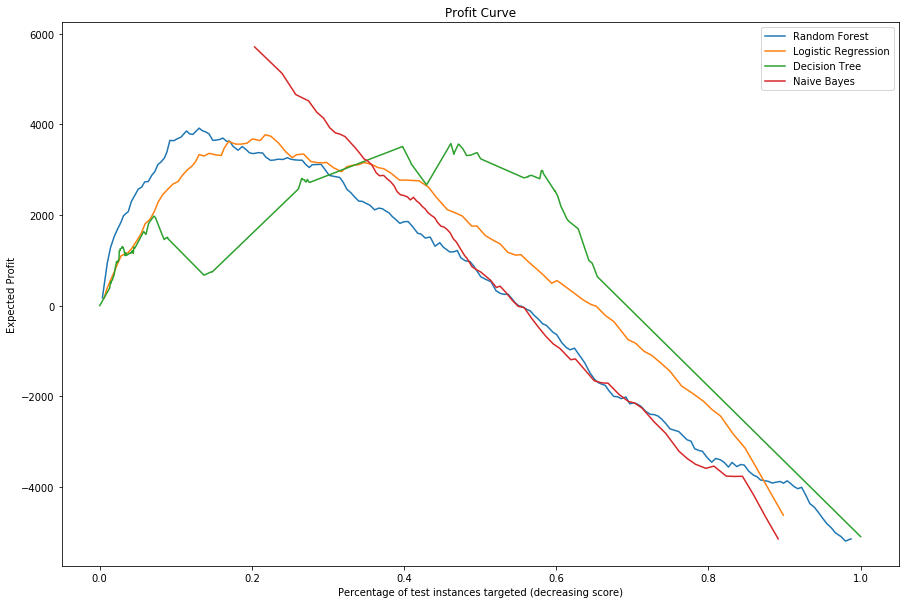

In [172]:
fig, ax = plt.subplots(figsize=(15, 10))


plt.plot(rf_x_array, rf_y_array, label='Random Forest', color=colour_coder("random_forest"))
plt.plot(logit_x_array, logit_y_array, label='Logistic Regression', color=colour_coder("logistic_regression"))
plt.plot(tree_x_array, tree_y_array, label='Decision Tree', color=colour_coder("decision_tree"))
plt.plot(bayes_x_array, bayes_y_array, label='Naive Bayes', color=colour_coder("naive_bayes"))

plt.xlabel("Percentage of test instances targeted (decreasing score)")
plt.ylabel("Expected Profit")
plt.title("Profit Curve")
plt.legend()
plt.show()

fig.savefig('ProfitCurve.png', dpi=300)

------------

## Tuning random forest model

`GridSearch` too slow

In [ ]:
#Learning Curves
accuracies_train = []
accuracies_test = []
accuracies_cv = []
rangedata = range(20000,58000,1000) #start at 100 to avoid 0 array
percent_range = [data/58000 for data in rangedata]


plt.figure(figsize=[10,7])

for i in percent_range:
    Y_train_rand = Y_train
    X_train_rand = X_new
    X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X_train_rand, Y_train_rand, test_size=1-i) #only really need traindata
    model = RandomForestClassifier()
    model.fit(X_train3, Y_train3) #fitting against the for-loop data 
    
    
    accuracies_train.append(metrics.accuracy_score(my_treelearning.predict(X_train), Y_train)) #accuracy against all training data
    accuracies_test.append(metrics.accuracy_score(my_treelearning.predict(X_test), Y_test)) #accuracy against all test data
    accuracies_cv.append(np.mean(cross_val_score(my_treelearning, X_train3, Y_train3, cv=3))) #cv with training data

plt.plot(rangedata, accuracies_train, label="Train")
plt.plot(rangedata, accuracies_test, label="Test")
plt.plot(rangedata, accuracies_cv, label="Cross-validation")
plt.title("Performance on train and test data")
plt.xlabel("Number of instances")
plt.ylabel("Accuracy")
plt.ylim([min(accuracies_test), 1.0])
plt.xlim(1,15001)
plt.legend()
plt.grid()
plt.show()

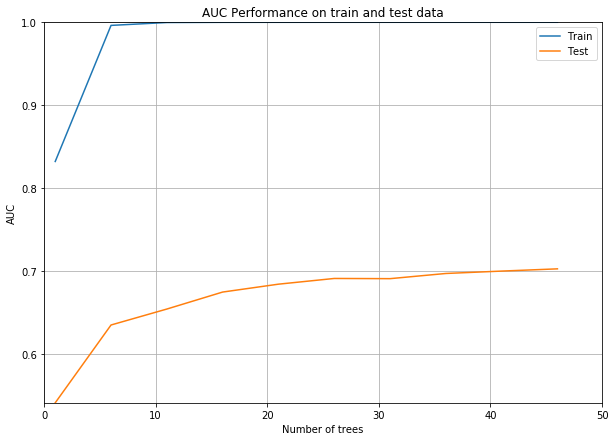

In [143]:
auc_train = []
auc_test = []
max_num_trees = 50
num_trees = range(1, max_num_trees)

plt.figure(figsize=[10,7])

for nt in num_trees:
    model = RandomForestClassifier(n_estimators=nt)
    model.fit(X_train, Y_train)
    
    # Get the probability of Y_test records being = 1
    Y_train_probability_1 = model.predict_proba(X_train)[:, 1]
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(Y_train, Y_train_probability_1)
    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(Y_test, Y_test_probability_1)
    
    auc_train.append(metrics.auc(fpr_train, tpr_train))
    auc_test.append(metrics.auc(fpr_test, tpr_test))
    
plt.plot(num_trees, auc_train, label="Train")
plt.plot(num_trees, auc_test, label="Test")
plt.title("AUC Performance on train and test data")
plt.xlabel("Number of trees")
plt.ylabel("AUC")
plt.ylim([min(auc_test), 1.0])
plt.xlim([0,max_num_trees])
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Construct something to check each feature contribution